#### This is a Jupyter Notebook running Python 3

To run a cell, type `Shift` + `Return`. Run the cell below to get started. This will initialize our environment

In [1]:
from workshop_utils import *
import pandas as pd; import seaborn as sns; import datetime
import matplotlib.pyplot as plt; import matplotlib.dates as mdates; import matplotlib.colors as colors; import matplotlib.ticker
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Make figures look good for hi-res displays.

## Statistics about all mappers who have made a HOT-related changeset

The query we just ran:
```sql
SELECT
    changesets.user,
    min(created_at) AS first_edit, 
    max(created_at) AS last_edit, 
    date_diff('day', min(created_at), max(created_at)) AS lifespan,
    sum(num_changes) AS total_edits
FROM 
    changesets
WHERE
    changesets.tags['comment'] LIKE '%hotosm%' -- hotosm changesets only
GROUP BY 
    changesets.user 
ORDER BY lifespan DESC
```

This query generated a CSV file with 140k rows, one per user who has made a HOT-related changeset. Now we want to obtain that CSV file, which was automatically saved to an Amazon S3 bucket.

### Getting the data from S3

The `load_dataframe_from_s3` function takes either the full URL: 

    https://us-east-2.console.aws.amazon.com/athena/query/results/23f6baab-b1c7-40b5-902c-42901f2447df/csv
    
Or just the 36 character `Query ID`:

    23f6baab-b1c7-40b5-902c-42901f2447df
    
This function downloads the query results to the `/www` directory (unless it already exists), and then returns a `Pandas DataFrame`. To run it, just paste either the URL or the query ID as a string (wrap in quotes) into the next cell: 

In [2]:
#Paste the link or query ID here: 
query = 'https://us-east-2.console.aws.amazon.com/athena/query/results/23f6baab-b1c7-40b5-902c-42901f2447df/csv'

In [3]:
#This next cell loads the data
df = load_dataframe_from_s3(query)

23f6baab-b1c7-40b5-902c-42901f2447df.csv
Creating dataframe... done.  Found 140,896 rows

We can look at the first few rows of our data with the `.head()` command:

In [4]:
df.head(2)

,user,first_edit,last_edit,lifespan,total_edits
0,673a,2012-02-18 09:39:59.000,2019-08-09 12:34:21.000,2729,9892
1,samlarsen1,2011-12-09 16:17:54.000,2019-03-21 14:44:00.000,2658,20815


Since we know our data is indexed by user and that first_edit and last_edit are dates, let's clean it up: 

In [5]:
df.set_index('user', inplace=True) #reset the index to usernames.
df.first_edit = df.first_edit.apply(lambda x: pd.Timestamp(x)) # cast to datetime
df.last_edit = df.last_edit.apply(lambda x: pd.Timestamp(x))   # cast to datetime
# simplify by day
df['first_day'] = df.first_edit.apply(pd.Timestamp.date)
df['last_day'] = df.last_edit.apply(pd.Timestamp.date)

In [6]:
#Let's see how we did: 
df.head(3)

,first_edit,last_edit,lifespan,total_edits,first_day,last_day
user,,,,,,
673a,2012-02-18 09:39:59,2019-08-09 12:34:21,2729,9892,2012-02-18,2019-08-09
samlarsen1,2011-12-09 16:17:54,2019-03-21 14:44:00,2658,20815,2011-12-09,2019-03-21
PierZen,2011-12-09 14:52:51,2019-02-15 21:20:41,2625,176416,2011-12-09,2019-02-15


## Question 1: When did each of these users make their first HOT-related edit?

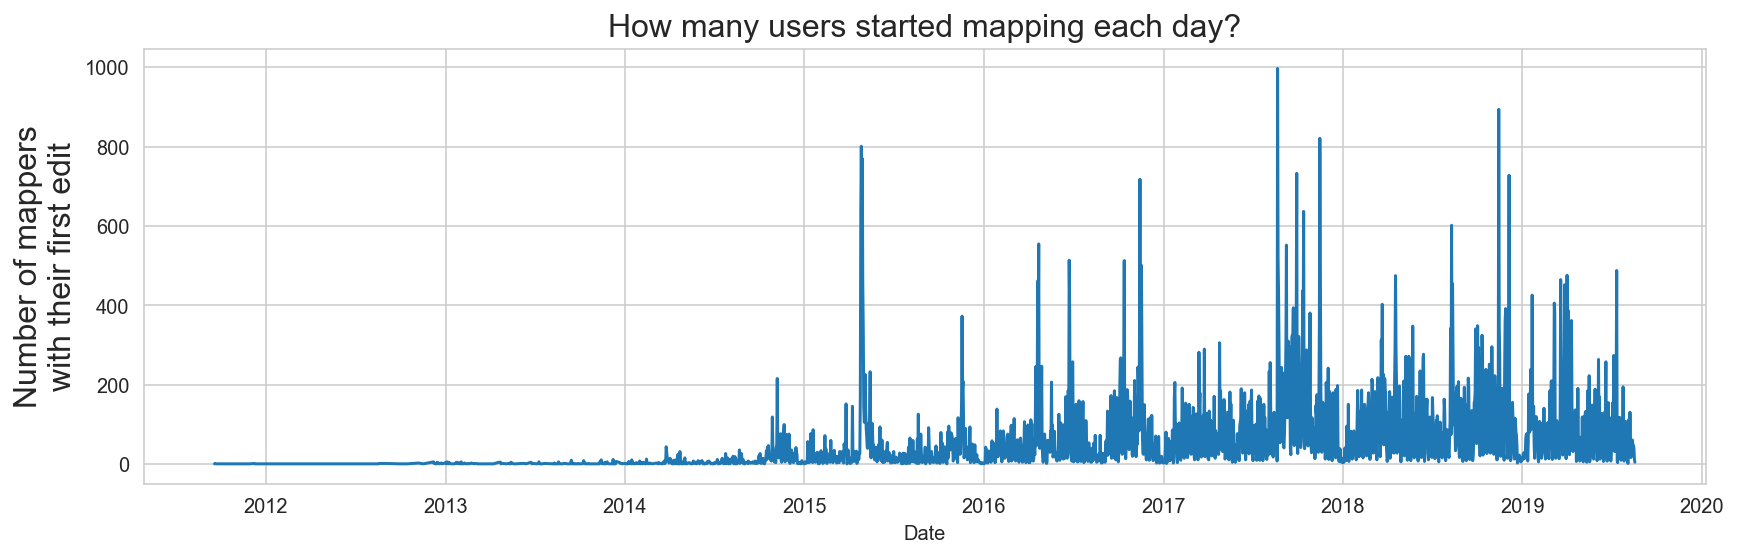

In [7]:
sns.set_style('whitegrid')
ax = df.groupby('first_day').aggregate('count')['total_edits'].plot(figsize=(14,4),legend=False)
ax.set_xlabel("Date"); ax.set_ylabel("Number of mappers\nwith their first edit", fontsize=16)
ax.set_title("How many users started mapping each day?", fontsize=16);

Each of these spikes likely correlate to major events that bring many new HOT mappers to OSM. The first large spike in April 2015 is the Nepal Earthquake mapping response.

## Question 2: How has the number of HOT mappers grown over time? 

Adding `.cumsum()` to get the cumulative sum per day, we can plot the growth: 

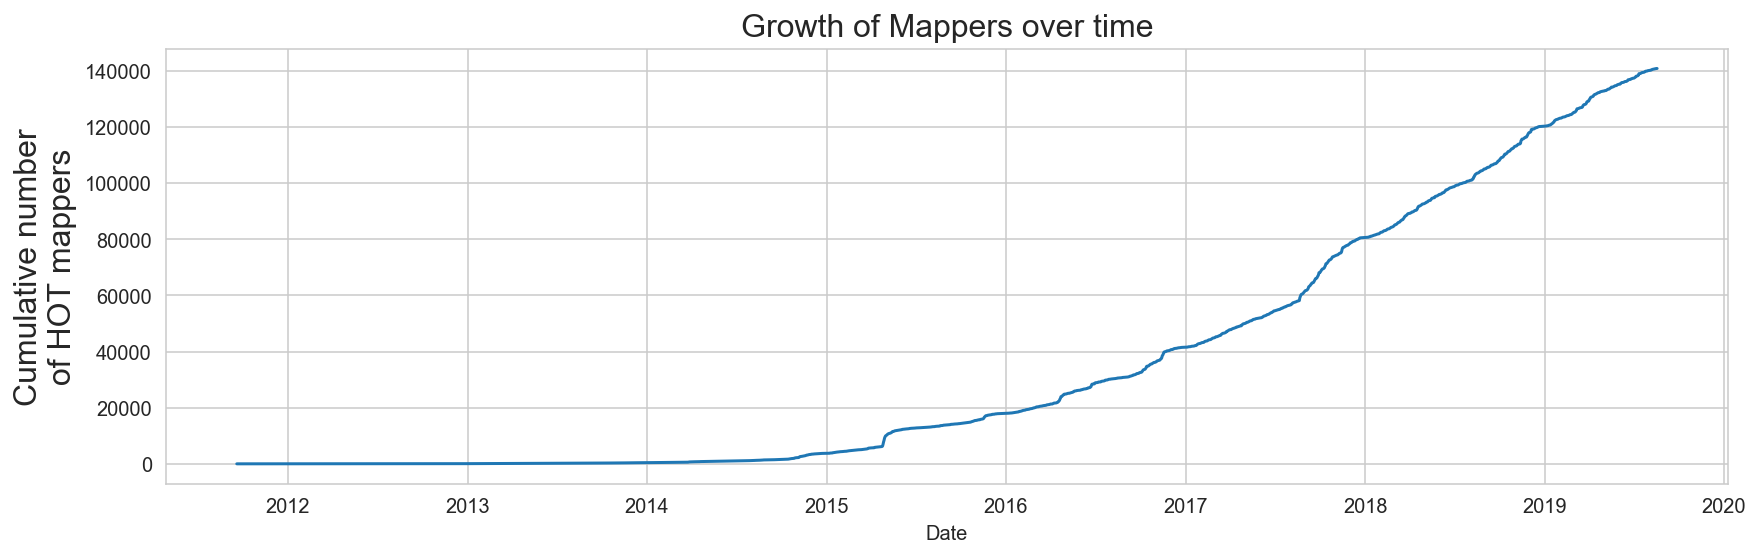

In [8]:
ax = df.groupby('first_day').aggregate('count')['total_edits'].cumsum().plot(figsize=(14,4))
ax.set_xlabel("Date"); 
ax.set_ylabel("Cumulative number\nof HOT mappers", fontsize=16)
ax.set_title("Growth of Mappers over time", fontsize=16);

## Question 3: How long to HOT mappers stick around? 

Using the `lifespan` attribute, we can explore how long mappers stay with a histogram:

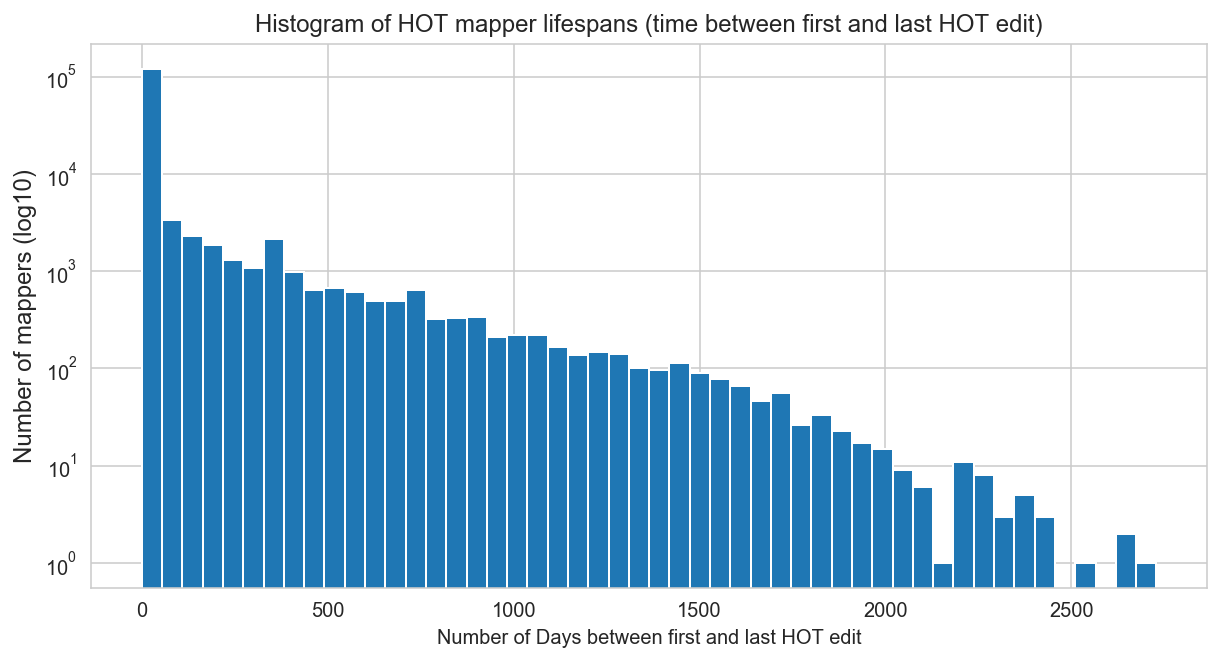

In [9]:
ax = df['lifespan'].plot(kind='hist',bins=50,figsize=(10,5))
ax.set_yscale('log')
ax.set_xlabel("Number of Days between first and last HOT edit"); ax.set_ylabel("Number of mappers (log10)", fontsize=12)
ax.set_title("Histogram of HOT mapper lifespans (time between first and last HOT edit)", fontsize=12);

Note the logscale to show detail. Over 100k users map for one day or less. (This is common with all online communities). If we want to confirm these results, we could run the following query: 

```sql
SELECT count(uid) FROM (
  SELECT uid, 
         count(id) AS num_changesets,
         date_diff('day', min(created_at), max(created_at)) AS lifespan
  FROM changesets
  WHERE lower(changesets.tags['comment']) LIKE '%hotosm%'
  GROUP BY uid
) WHERE lifespan > 1
```
This query returns ~ 35,374 rows, meaning that of our 140k HOT mappers, only 35k have mapped more than 1 day, so this figure showing that just over 100k users mapped only for 1 day seems accurate! (It's always good to cross-check our results)

## Question 4: Lifespan based on join date?

In [10]:
df.head()

,first_edit,last_edit,lifespan,total_edits,first_day,last_day
user,,,,,,
673a,2012-02-18 09:39:59,2019-08-09 12:34:21,2729,9892,2012-02-18,2019-08-09
samlarsen1,2011-12-09 16:17:54,2019-03-21 14:44:00,2658,20815,2011-12-09,2019-03-21
PierZen,2011-12-09 14:52:51,2019-02-15 21:20:41,2625,176416,2011-12-09,2019-02-15
Hartmut Holzgraefe,2012-04-23 07:17:41,2019-03-10 13:45:53,2512,115922,2012-04-23,2019-03-10
michael63,2012-12-08 15:07:47,2019-08-15 20:43:07,2441,625222,2012-12-08,2019-08-15


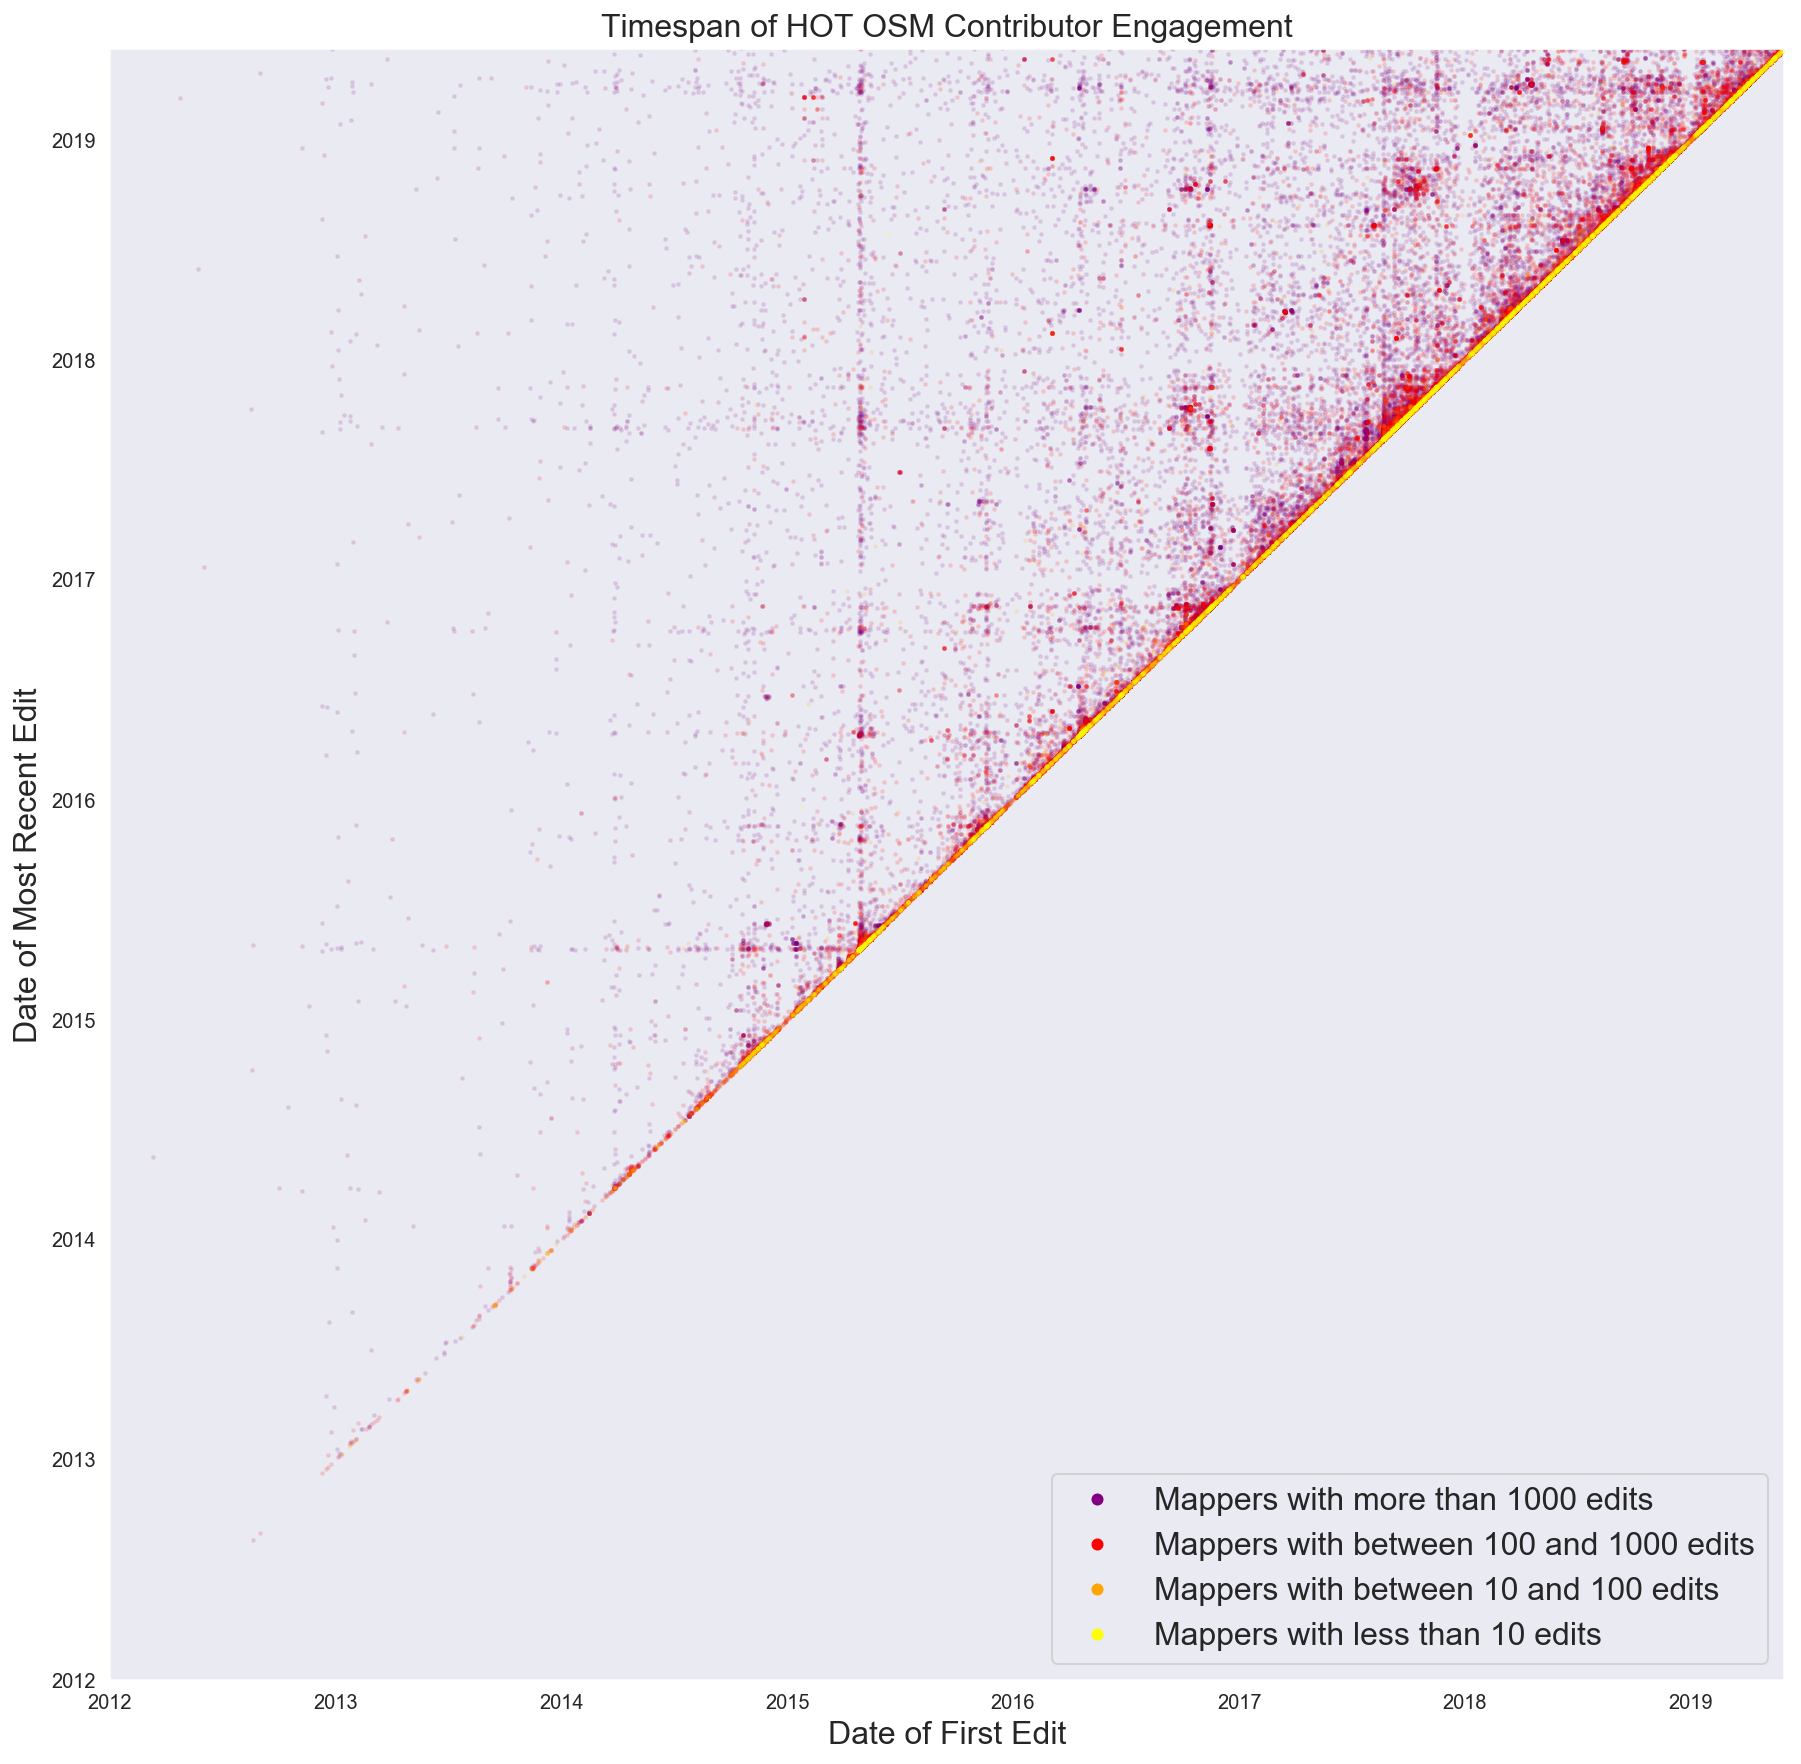

In [11]:
sns.set_style('dark')
plt.figure(num=None, figsize=(15, 15), facecolor='w', edgecolor='k')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().yaxis.set_major_locator(mdates.YearLocator())
plt.xlim([datetime.datetime(2012,1,1),datetime.datetime(2019,6,1)])
plt.ylim([datetime.datetime(2012,1,1),datetime.datetime(2019,6,1)])
plt.xlabel('Date of First Edit', fontsize=16)
plt.ylabel('Date of Most Recent Edit', fontsize=16)
plt.title("Timespan of HOT OSM Contributor Engagement",fontsize=16)

# few_edits  = df[df.sum_edits < 100]
# some_edits = df[((df.sum_edits >= 100) & (df.sum_edits < 1000))]
# most_edits = df[df.sum_edits >= 1000]

few_edits  = df[df.total_edits < 10]
some_edits = df[((df.total_edits >= 10) & (df.total_edits < 100))]
many_edits = df[((df.total_edits >= 100) & (df.total_edits < 1000))]
most_edits = df[df.total_edits >= 1000]

plt.plot(most_edits['first_edit'], most_edits['last_edit'], '.', markersize=3, alpha=0.1,color='purple');
plt.plot(many_edits['first_edit'], many_edits['last_edit'], '.', markersize=3, alpha=0.1,color='red');
plt.plot(some_edits['first_edit'], some_edits['last_edit'], '.', markersize=3, alpha=0.1,color='orange');
plt.plot(few_edits['first_edit'], few_edits['last_edit'], '.', markersize=3, alpha=0.1,color='yellow')

lgnd = plt.legend([
    'Mappers with more than 1000 edits',
    'Mappers with between 100 and 1000 edits',
    'Mappers with between 10 and 100 edits',
    'Mappers with less than 10 edits'
],fontsize=16);

#change the marker size manually for both lines
for lg in lgnd.legendHandles:
    lg._legmarker.set_markersize(10)
    lg._legmarker.set_alpha(1)

This particular visualization is a recreation of results from [this paper](https://www.researchgate.net/publication/324557333_The_life_cycle_of_contributors_in_collaborative_online_communities_-the_case_of_OpenStreetMap) by Daniel Bégin et al.

The yellow along the diagonal represent all of the 1-time contributors. However, the faint vertical lines represent mapping events that resulted in mappers sticking around; likewise, horizontal lines represent events where mappers who already had made HOT edits before participated in a single event and then didn't come back again.

## Next Steps

This concludes the _Tutorial_ notebook. Return to the [Jupyter Home](http://workshop.yetilabs.science:8000/aws-hot-workshop) and check out other notebooks with more queries regarding specific areas of the map, roads, buildings, and more.